# <div style="text-align: center; color: #1a5276;">Advanced Training</div>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3) 
4. [Data](#4) 
5. [Model](#5)
6. [Training](#6) <br>
    6.1. [Basic Training](#6.1) <br>
    6.2. [Including a progress bar](#6.2) <br>
    6.3. [Including a validation set and a custom metric](#6.3) <br>
    6.4. [Code improvement](#6.4) <br>
8. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

https://gemini.google.com/app/c49f12a5fb1aef13?hl=es

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

<a name="3"></a>
## <font color='blue'> 3. Data </font>

In [2]:
# binary data
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Synthetic binary data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split: 70% train, 15% val, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=0)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

# 1. Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)

# 2. Split data before scaling
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=0)

# 3. Fit scaler on training data only
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # Fit + transform train
X_val = scaler.transform(X_val)           # Transform val only
X_test = scaler.transform(X_test)         # Transform test only

# 4. Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 5. Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)


### Model

In [3]:
import torch
import torch.nn as nn

# device once
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden=16, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# instantiate two separate models
model1 = BinaryClassifier().to(DEVICE)
model2 = BinaryClassifier().to(DEVICE)




"""
# example: using CrossEntropyLoss (expects integer class labels 0 or 1)
criterion = nn.CrossEntropyLoss()

# dummy input and target
x = torch.randn(8, 20, device=DEVICE)          # batch of 8
y = torch.randint(0, 2, (8,), device=DEVICE)   # labels 0 or 1

logits1 = model1(x)  # shape (8,2)
loss1 = criterion(logits1, y)
"""

'\n# example: using CrossEntropyLoss (expects integer class labels 0 or 1)\ncriterion = nn.CrossEntropyLoss()\n\n# dummy input and target\nx = torch.randn(8, 20, device=DEVICE)          # batch of 8\ny = torch.randint(0, 2, (8,), device=DEVICE)   # labels 0 or 1\n\nlogits1 = model1(x)  # shape (8,2)\nloss1 = criterion(logits1, y)\n'

In [ ]:
y_val

### Simple training


que de momento incluye solo el entrenamiento y las metricas


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, metric_fn):
    model.train()
    running_loss, running_metric, total_samples = 0.0, 0.0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        running_metric += metric_fn(outputs, labels).item() * batch_size
        total_samples += batch_size

    return running_loss / total_samples, running_metric / total_samples if metric_fn else 0

In [ ]:
def validate_one_epoch(model, dataloader, criterion, device, metric_fn=None):
    model.eval()
    running_loss, running_metric, total_samples = 0.0, 0.0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            running_metric += metric_fn(outputs, labels).item() * batch_size
            total_samples += batch_size

    return running_loss / total_samples, running_metric / total_samples if metric_fn else 0

In [ ]:
def train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, device,
    metric_fn, epochs=10
):

    history = {'train_loss': [], 'val_loss': [], 'train_metric': [], 'val_metric': []}

    for epoch in range(1, epochs + 1):
        train_loss, train_metric = train_one_epoch(model, train_loader, criterion, optimizer, device, metric_fn)
        val_loss, val_metric = validate_one_epoch(model, val_loader, criterion, device, metric_fn)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metric'].append(train_metric)
        history['val_metric'].append(val_metric)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Metric: {train_metric:.4f} | "
              f"Val Loss: {val_loss:.4f}, Metric: {val_metric:.4f}")

    
    return model, history

test

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean()


In [ ]:
# Train with test set evaluation
model, history = train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, device,
    metric_fn=accuracy,
    epochs=10,
)

In [ ]:
# Final test set evaluation (only once)
test_loss, test_metric = validate_one_epoch(model, test_loader, criterion, device, accuracy)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Metric: {test_metric:.4f}")


### Several metrics

primero a mano, después con torchmetrics

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# --- 4. Define multiple metrics ---
def accuracy_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean()

from sklearn.metrics import precision_score

def precision_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return torch.tensor(precision_score(labels, preds, average='binary'))  # or 'macro'

metrics = {
    "accuracy": accuracy_fn,
    "precision": precision_fn
}


In [5]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, metrics):
    model.train()
    running_loss, total_samples = 0.0, 0
    metric_totals = {name: 0.0 for name in metrics} if metrics else {}

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        for name, fn in metrics.items():
            metric_totals[name] += fn(outputs, labels).item() * batch_size

    avg_loss = running_loss / total_samples
    avg_metrics = {name: total / total_samples for name, total in metric_totals.items()}

    return avg_loss, avg_metrics

In [6]:
def validate_one_epoch(model, dataloader, criterion, device, metrics=None):
    model.eval()
    running_loss, total_samples = 0.0, 0
    metric_totals = {name: 0.0 for name in metrics} if metrics else {}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

            for name, fn in metrics.items():
                metric_totals[name] += fn(outputs, labels).item() * batch_size

    avg_loss = running_loss / total_samples
    avg_metrics = {name: total / total_samples for name, total in metric_totals.items()}

    return avg_loss, avg_metrics

In [8]:
def train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, device,
    metrics, epochs=10
):

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, device, metrics)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for name in train_metrics:
            print(f"  Train {name}: {train_metrics[name]:.4f} | Val {name}: {val_metrics[name]:.4f}")


    return model, history

---> test

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = BinaryClassifier().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.01)


In [16]:
# --- 7. Run ---
trained_model, history = train_model(
    model4,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    device,
    metrics=metrics,
)

Epoch 01 | Train Loss: 0.5311 | Val Loss: 0.3098
  Train accuracy: 0.7743 | Val accuracy: 0.9400
  Train precision: 0.7339 | Val precision: 0.9425
Epoch 02 | Train Loss: 0.2111 | Val Loss: 0.1800
  Train accuracy: 0.9314 | Val accuracy: 0.9600
  Train precision: 0.9425 | Val precision: 0.9732
Epoch 03 | Train Loss: 0.1435 | Val Loss: 0.1767
  Train accuracy: 0.9429 | Val accuracy: 0.9600
  Train precision: 0.9551 | Val precision: 0.9732
Epoch 04 | Train Loss: 0.1191 | Val Loss: 0.1779
  Train accuracy: 0.9543 | Val accuracy: 0.9600
  Train precision: 0.9527 | Val precision: 0.9732
Epoch 05 | Train Loss: 0.1035 | Val Loss: 0.1877
  Train accuracy: 0.9643 | Val accuracy: 0.9467
  Train precision: 0.9651 | Val precision: 0.9722
Epoch 06 | Train Loss: 0.0948 | Val Loss: 0.1905
  Train accuracy: 0.9686 | Val accuracy: 0.9467
  Train precision: 0.9799 | Val precision: 0.9590
Epoch 07 | Train Loss: 0.0880 | Val Loss: 0.2042
  Train accuracy: 0.9714 | Val accuracy: 0.9467
  Train precision: 0.

NameError: name 'history' is not defined

In [ ]:
# Final test set evaluation (only once)
test_loss, test_metrics = validate_one_epoch(model, test_loader, criterion, device, metrics)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Metric: {test_metrics['accuracy']:.4f}")

with torchmetrics

In [ ]:
#!pip install torchmetrics

In [17]:
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision

# 4. Metric setup (torchmetrics)
metrics = {
    "accuracy": BinaryAccuracy().to(device), # necesita que le pase el argmax; poner como nota luego
    "precision": BinaryPrecision().to(device)
}

def reset_metrics(metrics):
    for metric in metrics.values():
        metric.reset()

def compute_metrics(metrics, preds, labels):
    results = {}
    for name, metric in metrics.items():
        metric.update(preds, labels)
    for name, metric in metrics.items():
        results[name] = metric.compute().item()
    return results


########################################################################


from torchmetrics.classification import Accuracy, Precision

num_classes = 2
is_binary = num_classes == 2
metrics = {
    "accuracy": Accuracy(task="binary" if is_binary else "multiclass", num_classes=num_classes).to(device),
    "precision": Precision(task="binary" if is_binary else "multiclass", num_classes=num_classes, average='macro').to(device)
}

def reset_metrics(metrics):
    for metric in metrics.values():
        metric.reset()

def compute_metrics(metrics):
    return {name: metric.compute().item() for name, metric in metrics.items()}




In [18]:
def train_one_epoch(model, loader, criterion, optimizer, device, metrics):
    model.train()
    total_loss, total_samples = 0.0, 0
    reset_metrics(metrics)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        preds = torch.argmax(outputs, dim=1)
        for metric in metrics.values():
            metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    final_metrics = compute_metrics(metrics)
    return avg_loss, final_metrics

In [19]:
def validate_one_epoch(model, loader, criterion, device, metrics):
    model.eval()
    total_loss, total_samples = 0.0, 0
    reset_metrics(metrics)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            for metric in metrics.values():
                metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    avg_metrics = compute_metrics(metrics)
    return avg_loss, avg_metrics

In [22]:
def train_model(model, train_loader, val_loader,
                criterion, optimizer, device,
                metrics, epochs=20, early_stopping_patience=3):


    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, device, metrics)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for k in train_metrics:
            print(f"  {k.capitalize()}: Train={train_metrics[k]:.4f}, Val={val_metrics[k]:.4f}")


    return model

In [24]:
model = BinaryClassifier().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# --- 7. Run ---
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    metrics=metrics,
)


Epoch 01 | Train Loss: 0.4980 | Val Loss: 0.2703
  Accuracy: Train=0.8143, Val=0.9333
  Precision: Train=0.7459, Val=0.9474
Epoch 02 | Train Loss: 0.1861 | Val Loss: 0.1751
  Accuracy: Train=0.9300, Val=0.9533
  Precision: Train=0.9448, Val=0.9733
Epoch 03 | Train Loss: 0.1401 | Val Loss: 0.1686
  Accuracy: Train=0.9414, Val=0.9600
  Precision: Train=0.9543, Val=0.9737
Epoch 04 | Train Loss: 0.1187 | Val Loss: 0.1745
  Accuracy: Train=0.9529, Val=0.9533
  Precision: Train=0.9397, Val=0.9610
Epoch 05 | Train Loss: 0.1099 | Val Loss: 0.1754
  Accuracy: Train=0.9543, Val=0.9533
  Precision: Train=0.9501, Val=0.9733
Epoch 06 | Train Loss: 0.0989 | Val Loss: 0.1863
  Accuracy: Train=0.9657, Val=0.9467
  Precision: Train=0.9539, Val=0.9605
Epoch 07 | Train Loss: 0.0922 | Val Loss: 0.1921
  Accuracy: Train=0.9700, Val=0.9533
  Precision: Train=0.9676, Val=0.9733
Epoch 08 | Train Loss: 0.0819 | Val Loss: 0.1989
  Accuracy: Train=0.9771, Val=0.9533
  Precision: Train=0.9736, Val=0.9733
Epoch 09

In [25]:
# Final test eval
test_loss, test_metrics = validate_one_epoch(model, test_loader, criterion, device, metrics)
print(f"\nTest Results: Loss={test_loss:.4f}")
for k, v in test_metrics.items():
    print(f"  Test {k.capitalize()}: {v:.4f}")


Test Results: Loss=0.1944
  Test Accuracy: 0.9600
  Test Precision: 0.9747


### Tracking history

In [26]:
def train_model(model, train_loader, val_loader,
                criterion, optimizer, device,
                metrics, epochs=20):

    best_val_loss = float('inf')
    best_model_state = None
    wait = 0
    history = {
        "train_loss": [], "val_loss": [],
        **{f"train_{k}": [] for k in metrics},
        **{f"val_{k}": [] for k in metrics}
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, device, metrics)
        

        # Logging
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        for k in train_metrics:
            history[f"train_{k}"].append(train_metrics[k])
            history[f"val_{k}"].append(val_metrics[k])

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for k in train_metrics:
            print(f"  {k.capitalize()}: Train={train_metrics[k]:.4f}, Val={val_metrics[k]:.4f}")


    return model, history



In [27]:
model = BinaryClassifier().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



# 7. Run
trained_model, history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, device,
    metrics=metrics,
    epochs=10,
)

Epoch 01 | Train Loss: 0.5058 | Val Loss: 0.2841
  Accuracy: Train=0.8200, Val=0.9533
  Precision: Train=0.8685, Val=0.9610
Epoch 02 | Train Loss: 0.1878 | Val Loss: 0.1549
  Accuracy: Train=0.9386, Val=0.9667
  Precision: Train=0.9405, Val=0.9740
Epoch 03 | Train Loss: 0.1317 | Val Loss: 0.1556
  Accuracy: Train=0.9471, Val=0.9533
  Precision: Train=0.9467, Val=0.9733
Epoch 04 | Train Loss: 0.1079 | Val Loss: 0.1548
  Accuracy: Train=0.9600, Val=0.9467
  Precision: Train=0.9587, Val=0.9730
Epoch 05 | Train Loss: 0.0944 | Val Loss: 0.1674
  Accuracy: Train=0.9671, Val=0.9400
  Precision: Train=0.9702, Val=0.9726
Epoch 06 | Train Loss: 0.0813 | Val Loss: 0.1662
  Accuracy: Train=0.9814, Val=0.9533
  Precision: Train=0.9851, Val=0.9733
Epoch 07 | Train Loss: 0.0713 | Val Loss: 0.1963
  Accuracy: Train=0.9786, Val=0.9467
  Precision: Train=0.9765, Val=0.9861
Epoch 08 | Train Loss: 0.0612 | Val Loss: 0.1897
  Accuracy: Train=0.9857, Val=0.9400
  Precision: Train=0.9853, Val=0.9726
Epoch 09

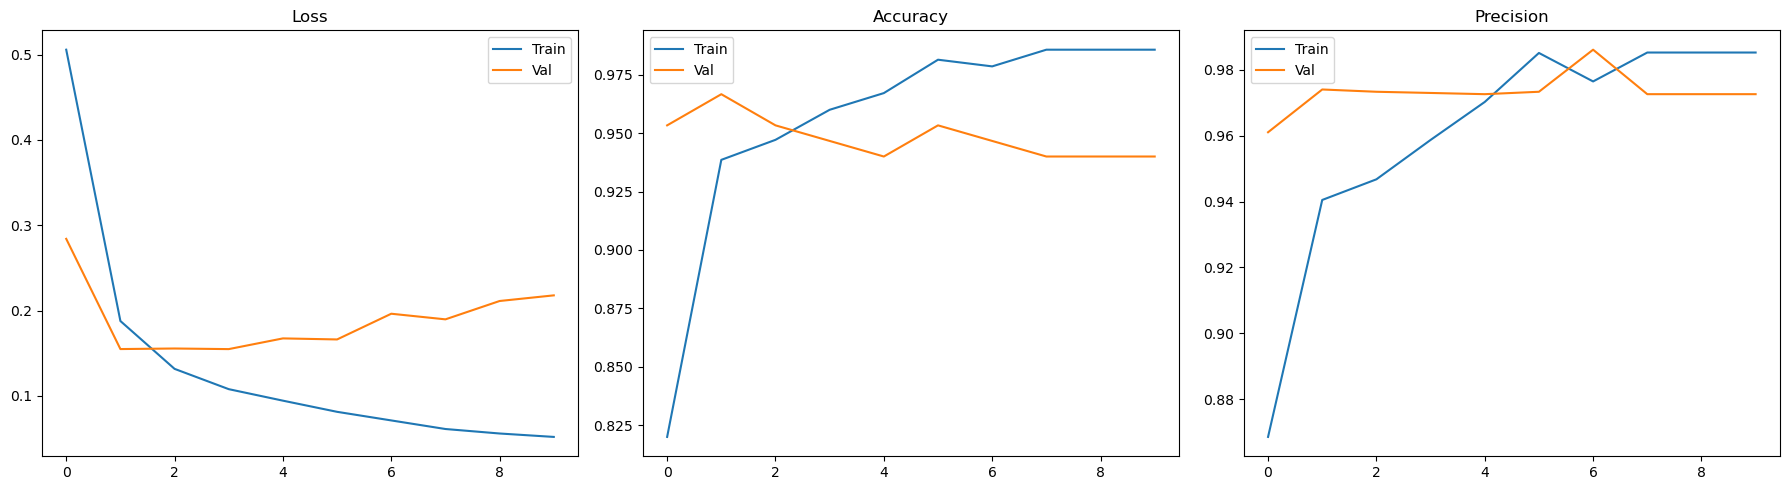

In [29]:
# plotting (and then tensrboard)
import matplotlib.pyplot as plt
#from torch.utils.tensorboard import SummaryWriter

# --- Plotting ---
def plot_history(history):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(history["train_loss"], label="Train")
    axs[0].plot(history["val_loss"], label="Val")
    axs[0].set_title("Loss")
    axs[0].legend()

    if "train_accuracy" in history:
        axs[1].plot(history["train_accuracy"], label="Train")
        axs[1].plot(history["val_accuracy"], label="Val")
        axs[1].set_title("Accuracy")
        axs[1].legend()

    if "train_precision" in history:
        axs[2].plot(history["train_precision"], label="Train")
        axs[2].plot(history["val_precision"], label="Val")
        axs[2].set_title("Precision")
        axs[2].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [30]:
# better way (implementing a class)

In [31]:
class TrainingLogger:
    def __init__(self, metric_names):
        # metric_names: list or iterable of metric keys expected in each epoch
        self.history = {
            'train_loss': [],
            'val_loss': [],
            **{f"train_{name}": [] for name in metric_names},
            **{f"val_{name}": [] for name in metric_names}
        }

    def log_epoch(self, train_loss, val_loss, train_metrics=None, val_metrics=None):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)

        if train_metrics:
            for name, value in train_metrics.items():
                self.history[f'train_{name}'].append(value)
        else:
            # Append None or skip? Here we append None to keep history lengths consistent
            for name in self.metric_names:
                self.history[f'train_{name}'].append(None)

        if val_metrics:
            for name, value in val_metrics.items():
                self.history[f'val_{name}'].append(value)
        else:
            for name in self.metric_names:
                self.history[f'val_{name}'].append(None)

    def print_epoch(self, epoch):
        train_loss = self.history['train_loss'][-1]
        val_loss = self.history['val_loss'][-1]

        train_metrics_str = ", ".join(
            f"{name}: {self.history[f'train_{name}'][-1]:.4f}"
            for name in self.metric_names
            if self.history[f'train_{name}'][-1] is not None
        )
        val_metrics_str = ", ".join(
            f"{name}: {self.history[f'val_{name}'][-1]:.4f}"
            for name in self.metric_names
            if self.history[f'val_{name}'][-1] is not None
        )

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} {train_metrics_str} | "
              f"Val Loss: {val_loss:.4f} {val_metrics_str}")

    @property
    def metric_names(self):
        # Extract metric names from history keys (train_*)
        # Assuming all train_ and val_ metrics have the same keys
        return [k[6:] for k in self.history if k.startswith('train_')]


In [32]:
def train_model(
    model, train_loader, val_loader,
    criterion, optimizer, device,
    metrics, epochs=10
):
    

    metric_names = list(metrics.keys())  # e.g. ['accuracy', 'f1', 'precision']
    logger = TrainingLogger(metric_names)

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, device, metrics)

        # Log
        logger.log_epoch(train_loss, val_loss, train_metrics, val_metrics)
        logger.print_epoch(epoch)


    return model, logger.history


In [37]:
model = BinaryClassifier().to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 7. Run
trained_model, history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, device,
    metrics=metrics,
    epochs=20,
)

Epoch 01 | Train Loss: 0.6960 loss: 0.6960, accuracy: 0.5343, precision: 0.5107 | Val Loss: 0.6664 loss: 0.6664, accuracy: 0.5867, precision: 0.5645
Epoch 02 | Train Loss: 0.6391 loss: 0.6391, accuracy: 0.6900, precision: 0.6255 | Val Loss: 0.6171 loss: 0.6171, accuracy: 0.7333, precision: 0.7021
Epoch 03 | Train Loss: 0.5852 loss: 0.5852, accuracy: 0.7900, precision: 0.7513 | Val Loss: 0.5663 loss: 0.5663, accuracy: 0.8333, precision: 0.8442
Epoch 04 | Train Loss: 0.5290 loss: 0.5290, accuracy: 0.8643, precision: 0.8697 | Val Loss: 0.5132 loss: 0.5132, accuracy: 0.8600, precision: 0.9014
Epoch 05 | Train Loss: 0.4721 loss: 0.4721, accuracy: 0.8843, precision: 0.9135 | Val Loss: 0.4580 loss: 0.4580, accuracy: 0.8600, precision: 0.9130
Epoch 06 | Train Loss: 0.4161 loss: 0.4161, accuracy: 0.9071, precision: 0.9419 | Val Loss: 0.4032 loss: 0.4032, accuracy: 0.8867, precision: 0.9552
Epoch 07 | Train Loss: 0.3647 loss: 0.3647, accuracy: 0.9129, precision: 0.9455 | Val Loss: 0.3548 loss: 0

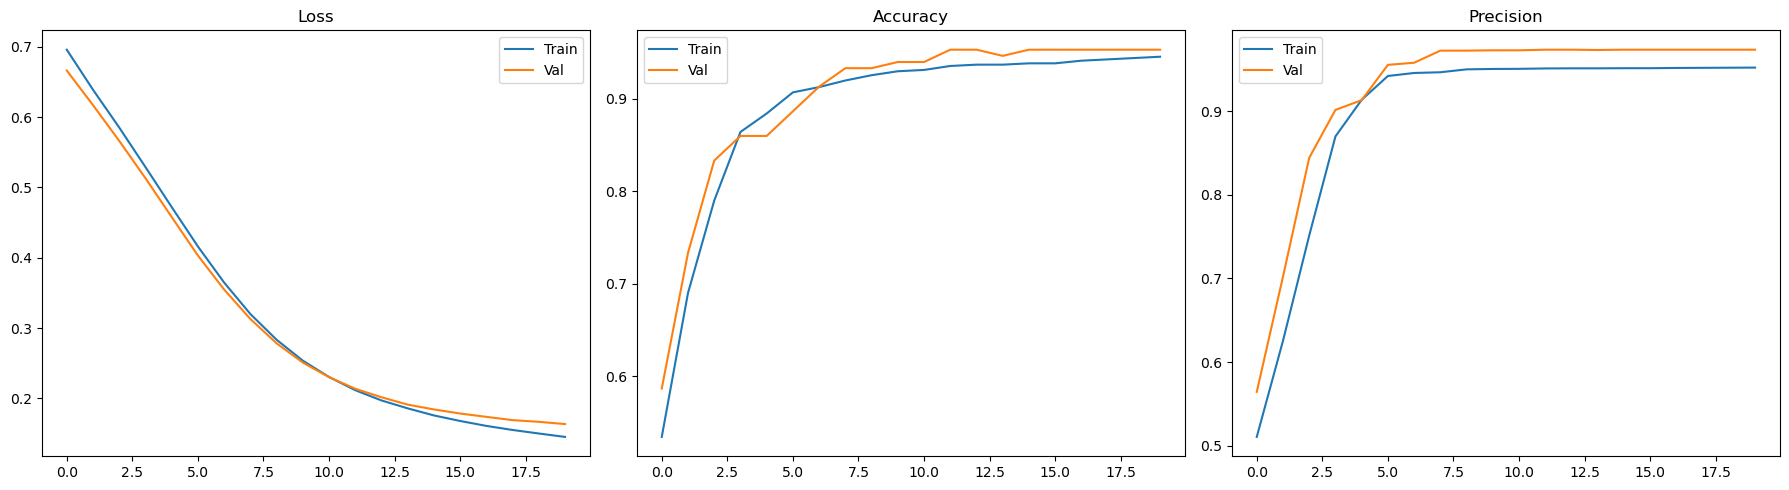

In [38]:
plot_history(history)

### Early stopping